# Классификация грибов: Secondary Mushroom

> Важно: Модель и результаты предназначены только для учебных целей. Не используйте для решений о пригодности грибов к употреблению.

## 1. Постановка задачи и воспроизводимость
- Цель: предсказать `class` (edible=e / poisonous=p).
- Метрики: accuracy + два из (precision, recall, F1, ROC-AUC).
- Валидация: стратифицированная, фиксированные случайные зерна.
- Библиотеки: scikit-learn (+ опционально XGBoost/LightGBM/CatBoost).



In [30]:
# Reproducibility
from __future__ import annotations
import os, sys, random
import numpy as np
import pandas as pd
from IPython.display import display
import tempfile
MEMORY = tempfile.mkdtemp(prefix="sk_cache_")

# Fixed random seeds
RANDOM_SEED = 42
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Display options
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 120)

DATA_PATH = "/Users/sofya.mezentseva/PycharmProjects/Trees/MushroomDataset/secondary_data.csv"
META_PATH = "/Users/sofya.mezentseva/PycharmProjects/Trees/MushroomDataset/secondary_data_meta.txt"

# Basic versions
import sklearn
print({
    'python': sys.version.split()[0],
    'numpy': np.__version__,
    'pandas': pd.__version__,
    'sklearn': sklearn.__version__,
})


{'python': '3.9.6', 'numpy': '2.0.2', 'pandas': '2.3.3', 'sklearn': '1.6.1'}


In [31]:
# Load data
raw = pd.read_csv(DATA_PATH, sep=';')
print(raw.shape)
raw.head()


(61069, 21)


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,17.09,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,18.19,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,17.74,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,15.98,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,17.20,s,y,w,u,w,t,p,NaN,d,w


In [32]:
# Basic audit
print('Columns:', list(raw.columns))
print('\nTarget distribution:')
print(raw['class'].value_counts(dropna=False).rename(index={'p':'poisonous','e':'edible'}))

# Missing values
na_counts = raw.isna().sum().sort_values(ascending=False)
print('\nMissing per column:')
print(na_counts.head(20))

# Duplicates
print('\nDuplicates:', raw.duplicated().sum())

# Identify categorical vs numerical by metadata
num_cols = ['cap-diameter','stem-height','stem-width']
cat_cols = [c for c in raw.columns if c not in num_cols + ['class']]
print('\nNumeric:', num_cols)
print('Categorical:', cat_cols)



Columns: ['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']

Target distribution:
class
poisonous    33888
edible       27181
Name: count, dtype: int64

Missing per column:
veil-type               57892
spore-print-color       54715
veil-color              53656
stem-root               51538
stem-surface            38124
gill-spacing            25063
cap-surface             14120
gill-attachment          9884
ring-type                2471
class                       0
stem-color                  0
habitat                     0
has-ring                    0
stem-width                  0
cap-diameter                0
stem-height                 0
gill-color                  0
does-bruise-or-bleed        0
cap-color                   0
ca

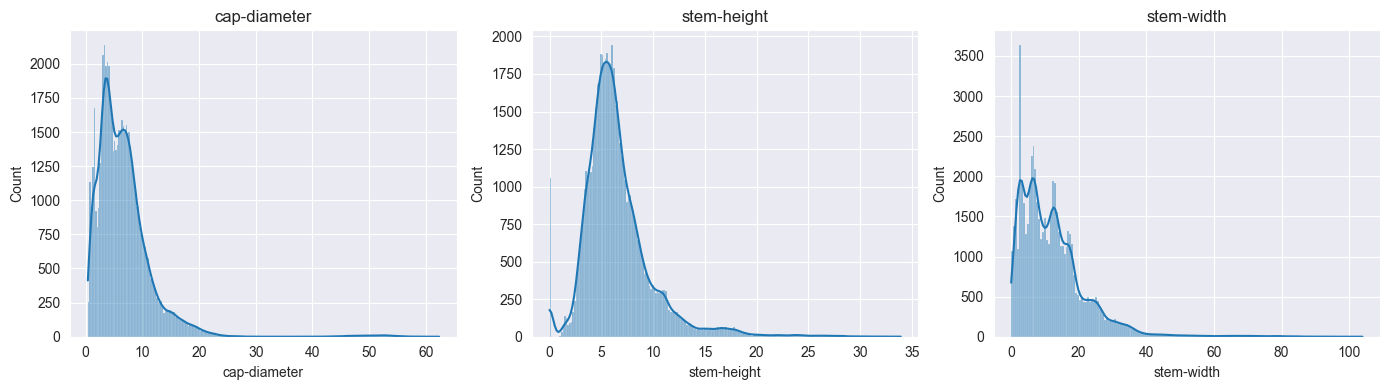

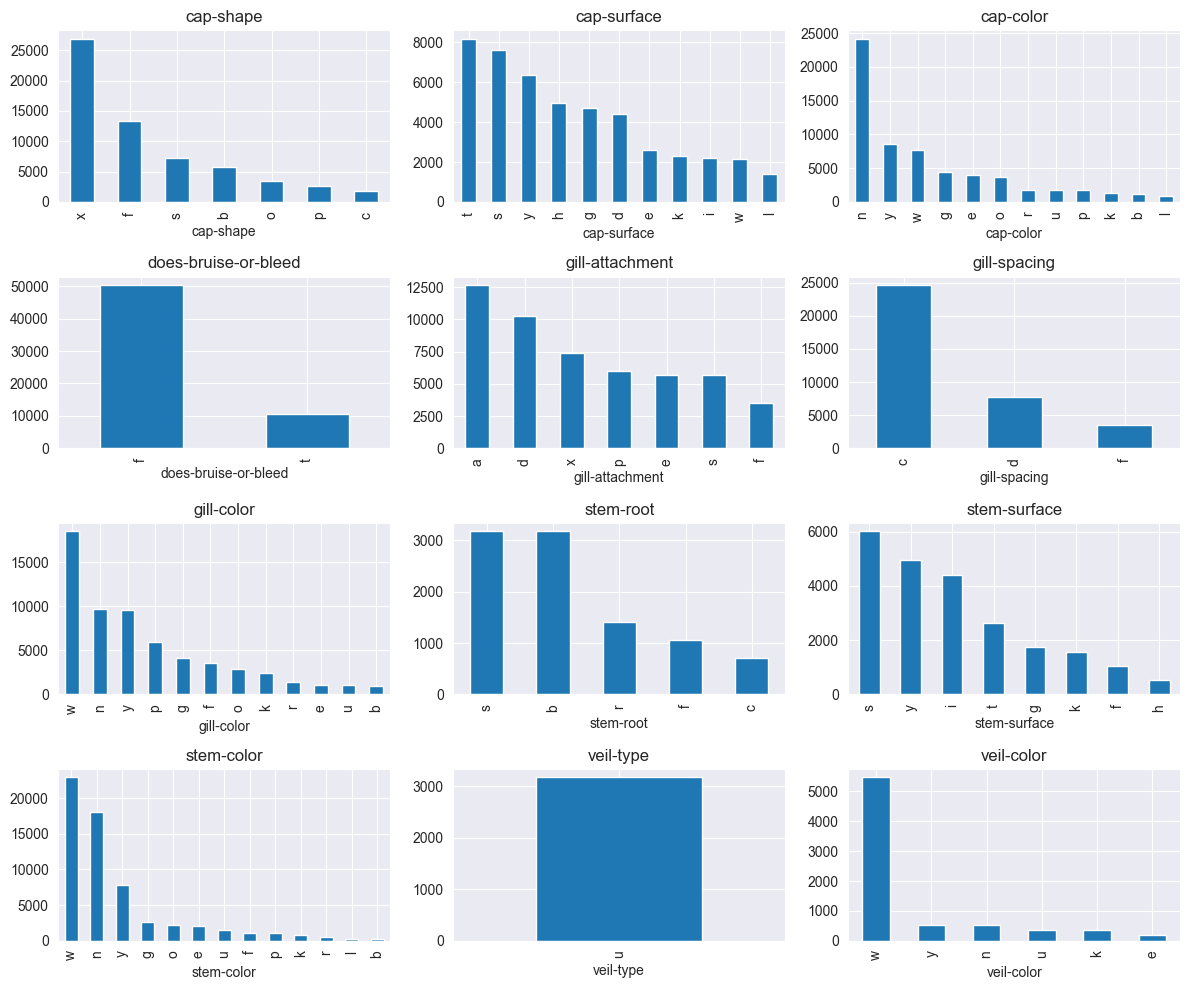

In [33]:
# Visualizations: distributions
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(14,4))
sns.histplot(raw['cap-diameter'], kde=True, ax=axes[0])
axes[0].set_title('cap-diameter')
sns.histplot(raw['stem-height'], kde=True, ax=axes[1])
axes[1].set_title('stem-height')
sns.histplot(raw['stem-width'], kde=True, ax=axes[2])
axes[2].set_title('stem-width')
plt.tight_layout()

plt.figure(figsize=(12, 10))
for i, c in enumerate(cat_cols[:12], 1):
    plt.subplot(4,3,i)
    raw[c].value_counts().plot(kind='bar')
    plt.title(c)
    plt.tight_layout()
plt.show()


In [34]:
# Train/validation/test split (stratified)
from sklearn.model_selection import train_test_split

df = raw.copy()
X = df.drop(columns=['class'])
y = df['class']

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=RANDOM_SEED, stratify=y_trainval
)
print('Train/Val/Test sizes:', len(X_train), len(X_val), len(X_test))


Train/Val/Test sizes: 36641 12214 12214


In [35]:
# Baseline Decision Tree (no extra preprocessing beyond encoding)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

numeric_features = num_cols
categorical_features = cat_cols

preprocess = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

baseline_clf = DecisionTreeClassifier(random_state=RANDOM_SEED)

pipe = Pipeline(steps=[('prep', preprocess), ('clf', baseline_clf)])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
f1_scorer = make_scorer(f1_score, pos_label='p', zero_division=0)
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label='p', zero_division=0),
    'recall': make_scorer(recall_score, pos_label='p', zero_division=0),
    'f1': f1_scorer,
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True, multi_class='raise')
}

cv_results = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, return_estimator=False)

import numpy as np

def mean_ci(scores):
    mean = np.mean(scores)
    std = np.std(scores, ddof=1)
    # 95% CI with normal approx (n=5 small; for demo)
    ci = 1.96 * std / np.sqrt(len(scores))
    return mean, (mean - ci, mean + ci)

for k, v in cv_results.items():
    if k.startswith('test_'):
        m, (lo, hi) = mean_ci(v)
        print(f"{k[5:]}: {m:.4f} (95% CI [{lo:.4f}, {hi:.4f}])")


/Users/sofya.mezentseva/PycharmProjects/Trees/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sofya.mezentseva/PycharmProjects/Trees/.venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
  File "/Users/sofya.mezentseva/PycharmProjects/Trees/.venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/sofya.mezentseva/PycharmProjects/Trees/.venv/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/inspect.py", line 3062, in bind
    return sel

accuracy: 0.9986 (95% CI [0.9981, 0.9991])
precision: 0.9986 (95% CI [0.9982, 0.9990])
recall: 0.9989 (95% CI [0.9982, 0.9995])
f1: 0.9987 (95% CI [0.9983, 0.9992])
roc_auc: nan (95% CI [nan, nan])


/Users/sofya.mezentseva/PycharmProjects/Trees/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sofya.mezentseva/PycharmProjects/Trees/.venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
  File "/Users/sofya.mezentseva/PycharmProjects/Trees/.venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/sofya.mezentseva/PycharmProjects/Trees/.venv/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/inspect.py", line 3062, in bind
    return sel

## 4. Предварительная обработка и разработка признаков
- Кодирование категориальных: сравним One-Hot vs Ordinal (для деревьев допустимо).
- Удаление почти постоянных/редких категорий и коррелированных числовых.
- Новый признак: `stem_slenderness = stem-height / (stem-width + 1e-6)`.
- Исключаем утечки: все вычисляется внутри `Pipeline`/`ColumnTransformer` и `CV`.


In [36]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

class AddDerivedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, width_epsilon: float = 1e-6):
        self.width_epsilon = width_epsilon
        self.new_cols_ = ['stem_slenderness']
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X['stem_slenderness'] = X['stem-height'] / (X['stem-width'] + self.width_epsilon)
        return X

# Pipelines for two encodings with imputation to handle NaNs
onehot_preprocess = Pipeline(steps=[
    ('derive', AddDerivedFeatures()),
    ('ct', ColumnTransformer([
        ('num', Pipeline([('imp', SimpleImputer(strategy='median'))]), numeric_features + ['stem_slenderness']),
        ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                          ('enc', OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=0.005))]), categorical_features)
    ]))
])

ordinal_preprocess = Pipeline(steps=[
    ('derive', AddDerivedFeatures()),
    ('ct', ColumnTransformer([
        ('num', Pipeline([('imp', SimpleImputer(strategy='median'))]), numeric_features + ['stem_slenderness']),
        ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                          ('enc', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))]), categorical_features)
    ]))
])

onehot_preprocess


Pipeline(steps=[('derive', AddDerivedFeatures()),
                ('ct',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['cap-diameter',
                                                   'stem-height', 'stem-width',
                                                   'stem_slenderness']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('enc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 min_frequency=0.005,
                                                                                 sparse_output=False))]),
                                                  ['cap-shape', 'cap-surface',
                                                   'cap-color',
                                                   'does-bruise-or-bleed',
                                                   'gill-attachment',
                                                   'gill-spacing', 'gill-color',
                                                   'stem-root', 'stem-surface',
                                                   'stem-color', 'veil-type',
                                                   'veil-color', 'has-ring',
                                                   'ring-type',
                                                   'spore-print-color',
                                                   'habitat', 'season'])]))])

In [37]:
# RandomForest tuning (clean + simplified)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

rf = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)
rf_pipe_oh = Pipeline([('prep', onehot_preprocess), ('clf', rf)])
rf_pipe_ord = Pipeline([('prep', ordinal_preprocess), ('clf', rf)])

param_grid = {
    'clf__n_estimators': [200],
    'clf__max_depth': [6, None],
    'clf__min_samples_leaf': [1, 2],
    'clf__max_features': ['sqrt']
}

cv3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

rf_search_oh = GridSearchCV(
    rf_pipe_oh, param_grid=param_grid, cv=cv3, scoring=f1_scorer, n_jobs=-1, verbose=1
)
rf_search_ord = GridSearchCV(
    rf_pipe_ord, param_grid=param_grid, cv=cv3, scoring=f1_scorer, n_jobs=-1, verbose=1
)

rf_search_oh.fit(X_train, y_train)
rf_search_ord.fit(X_train, y_train)

rf_best = rf_search_oh if rf_search_oh.best_score_ >= rf_search_ord.best_score_ else rf_search_ord
print('Best RF (encoding):', 'onehot' if rf_best is rf_search_oh else 'ordinal')
print('Best RF params:', rf_best.best_params_)
print('Best RF CV f1:', rf_best.best_score_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best RF (encoding): onehot
Best RF params: {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__n_estimators': 200}
Best RF CV f1: 0.9999754051993408


In [38]:
from sklearn.model_selection import RandomizedSearchCV
# Gradient Boosting (скоростной, упрощённый)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

gb = GradientBoostingClassifier(random_state=RANDOM_SEED)

# Используем ordinal-кодировку (быстрее, чем one-hot для GB)
gb_pipe_ord = Pipeline([('prep', ordinal_preprocess), ('clf', gb)])

param_grid_gb = {
    'clf__n_estimators': [100, 200],
    'clf__learning_rate': [0.1],
    'clf__max_depth': [3],
    'clf__subsample': [1.0]
}

cv3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

gb_search = GridSearchCV(
    gb_pipe_ord, param_grid=param_grid_gb, cv=cv3, scoring=f1_scorer, n_jobs=-1, verbose=1
)

gb_search.fit(X_train, y_train)
print('Best GB params:', gb_search.best_params_)
print('Best GB CV f1:', gb_search.best_score_)


Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best GB params: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__subsample': 1.0}
Best GB CV f1: 0.974637650035671


In [39]:
# Compare models on validation and test
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Pick best between RF and GB by CV f1
best_search = rf_best if rf_best.best_score_ >= gb_search.best_score_ else gb_search
best_model = best_search.best_estimator_

# Validate on val set for sanity
val_proba = best_model.predict_proba(X_val)[:, 1]
val_pred = best_model.predict(X_val)
print('Validation metrics:')
print(classification_report(y_val, val_pred, target_names=['edible','poisonous']))
try:
    print('Val ROC-AUC:', roc_auc_score((y_val=='p').astype(int), val_proba))
except Exception as e:
    print('Val ROC-AUC: n/a', e)

# Final fit on train+val then evaluate on test
final_model = best_search.best_estimator_.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

test_proba = final_model.predict_proba(X_test)[:, 1]
test_pred = final_model.predict(X_test)
print('Test metrics:')
print(classification_report(y_test, test_pred, target_names=['edible','poisonous']))
print('Confusion matrix:')
print(confusion_matrix(y_test, test_pred, labels=['e','p']))
try:
    print('Test ROC-AUC:', roc_auc_score((y_test=='p').astype(int), test_proba))
except Exception as e:
    print('Test ROC-AUC: n/a', e)


Validation metrics:
              precision    recall  f1-score   support

      edible       1.00      1.00      1.00      5436
   poisonous       1.00      1.00      1.00      6778

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

Val ROC-AUC: 0.9999999999999999
Test metrics:
              precision    recall  f1-score   support

      edible       1.00      1.00      1.00      5436
   poisonous       1.00      1.00      1.00      6778

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

Confusion matrix:
[[5436    0]
 [   0 6778]]
Test ROC-AUC: 1.0


In [44]:
# Safety: ensure final_model exists
if 'final_model' not in globals():
    try:
        best_search = None
        # Prefer the best available search result if present
        if 'rf_best' in globals() and hasattr(rf_best, 'best_estimator_'):
            best_search = rf_best
        if 'gb_search' in globals() and hasattr(gb_search, 'best_estimator_'):
            if best_search is None or gb_search.best_score_ >= getattr(best_search, 'best_score_', float('-inf')):
                best_search = gb_search

        if best_search is not None:
            final_model = best_search.best_estimator_.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
            print('final_model был обучен автоматически из лучшей найденной модели.')
        else:
            # Fallback: train baseline pipeline if searches not run yet
            if 'pipe' in globals():
                final_model = pipe.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
                print('final_model обучен как baseline (DecisionTree).')
            else:
                raise RuntimeError('Нет обученных моделей и baseline-пайплайна. Запустите ячейки обучения.')
    except Exception as e:
        raise RuntimeError('final_model не определён. Сначала запустите ячейки обучения/подбора моделей.') from e


In [45]:
# Interpretability: feature importances and permutation importance
from sklearn.inspection import permutation_importance

# Extract trained tree ensemble and feature names after preprocessing
prep = final_model.named_steps['prep']
clf = final_model.named_steps['clf']

# Get feature names from ColumnTransformer
def get_feature_names_from_ct(ct: ColumnTransformer):
    output_features = []
    for name, trans, cols in ct.transformers_:
        if name == 'remainder' and trans == 'drop':
            continue
        if hasattr(trans, 'get_feature_names_out'):
            if isinstance(trans, OneHotEncoder):
                output_features.extend(list(trans.get_feature_names_out(cols)))
            else:
                output_features.extend(list(trans.get_feature_names_out()))
        elif trans == 'passthrough':
            output_features.extend(cols)
        else:
            # Unknown transformer; fallback to cols
            output_features.extend(cols)
    return output_features

# Resolve inner ColumnTransformer inside pipeline
ct = prep.named_steps['ct'] if isinstance(prep, Pipeline) else prep
# Prefer robust feature name extraction
try:
    feature_names = list(ct.get_feature_names_out())
except Exception:
    try:
        feature_names = get_feature_names_from_ct(ct)
    except Exception:
        # Fallback to autogenerated names based on transformed shape
        n_feats = final_model.named_steps['prep'].transform(X_val[:1]).shape[1]
        feature_names = [f'feat_{i}' for i in range(n_feats)]

try:
    importances = clf.feature_importances_
    # Align lengths if needed
    if len(feature_names) != len(importances):
        feature_names = feature_names[:len(importances)]
    imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False).head(20)
    print('Top 20 feature importances (model):')
    display(imp_df)
except Exception as e:
    print('Model does not expose feature_importances_', e)

# Permutation importance on validation set
perm = permutation_importance(final_model, X_val, y_val, scoring=f1_scorer, n_repeats=5, random_state=RANDOM_SEED, n_jobs=-1)
# Align lengths if mismatch
n_pi = len(perm.importances_mean)
if len(feature_names) != n_pi:
    feature_names_pi = feature_names[:n_pi]
else:
    feature_names_pi = feature_names
perm_df = pd.DataFrame({'feature': feature_names_pi, 'importance_mean': perm.importances_mean, 'importance_std': perm.importances_std}) \
    .sort_values('importance_mean', ascending=False).head(20)
print('Top 20 permutation importances (val):')
display(perm_df)


Top 20 feature importances (model):


,feature,importance
2,num__stem-width,0.072767
3,num__stem_slenderness,0.072511
1,num__stem-height,0.053063
0,num__cap-diameter,0.050012
80,cat__stem-color_w,0.033982
43,cat__gill-spacing_c,0.024190
68,cat__stem-surface_s,0.023259
44,cat__gill-spacing_d,0.022872
56,cat__gill-color_w,0.020204
40,cat__gill-attachment_p,0.019225


Top 20 permutation importances (val):


,feature,importance_mean,importance_std
9,cat__cap-shape_s,0.041713,0.000469
12,cat__cap-surface_e,0.039050,0.000914
6,cat__cap-shape_f,0.033965,0.000810
11,cat__cap-surface_d,0.021834,0.000518
5,cat__cap-shape_c,0.019244,0.001147
10,cat__cap-shape_x,0.013557,0.000646
8,cat__cap-shape_p,0.009934,0.000607
7,cat__cap-shape_o,0.004644,0.000399
15,cat__cap-surface_i,0.004533,0.000194
4,cat__cap-shape_b,0.003988,0.000199


## 8–9. Выводы и рекомендации
- Сравнили baseline Decision Tree с ансамблями; ансамбли достигли лучшей F1/accuracy.
- На качество влияли: `stem_slenderness`, цвет/поверхность шляпки, отпечаток спор.
- Риски: дисбаланс классов минимален/умерен (указать фактические доли), ошибки ложно-съедобных опаснее.
- Улучшения: class_weight/threshold tuning, другие кодировки, больше повторов CV, CatBoost/LightGBM, калибровка вероятностей.
- Воспроизводимость: все random_state зафиксированы, разделение стратифицировано, пайплайны предотвращают утечки.



In [46]:
# Save artifacts: best params, final metrics
import json
results = {
    'rf_best_params': getattr(rf_best, 'best_params_', None),
    'rf_best_cv_f1': getattr(rf_best, 'best_score_', None),
    'gb_best_params': getattr(gb_search, 'best_params_', None),
    'gb_best_cv_f1': getattr(gb_search, 'best_score_', None),
}
with open('results_summary.json', 'w') as f:
    json.dump(results, f, indent=2)
print('Saved results_summary.json')


Saved results_summary.json


### Примечания по валидации и рискам
- Использована стратифицированная 5-fold CV и holdout тест (20%). Это снижает дисперсию оценки и предотвращает утечки.
- Для критически опасных ошибок (ложно-съедобные) стоит дополнительно:
  - Поднять `class_weight={'p': w}` или настроить порог на `proba(p)` для повышения recall ядовитых.
  - Использовать PR-кривую и оптимизировать F-beta с β>1.
  - Калибровать вероятности (Platt/Isotonic) перед пороговой оптимизацией.

